# Prerequisites

In [1]:
import sys

sys.path.append("..")

In [2]:
%load_ext autoreload
%autoreload 2

import argparse
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision.transforms.v2 as transforms
from IPython.display import display
from torchvision.models import resnet18, resnet50
from torchvision.ops import masks_to_boxes
from torchvision.transforms.v2.functional import to_image
from torchvision.tv_tensors import BoundingBoxes
from tqdm.notebook import tqdm

from dataset import (
    HWSetNoise,
    get_dloader,
    normalize_hw,
    normalize_hw_mask,
    normalize_inv_hw,
    normalize_inv_hw_mask,
    transform_shared,
)
from util import show_imarray

In [3]:
data_dir = "../data"
class_legend = ("Siberian Husky", "Grey Wolf")
model_types = {"r18": "ResNet 18", "r50": "Resnet 50"}

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")


def get_model(model_type, device="cpu", seed=191510):
    torch.manual_seed(seed)
    if model_type == "r18":
        model = resnet18(weights=None)
    elif model_type == "r50":
        model = resnet50(weights=None)
    model.fc = torch.nn.Linear(
        in_features=model.fc.in_features, out_features=len(class_legend), bias=True
    )
    model.to(device)
    return model

Using device: cuda


# RandomIoUCrop

In [101]:
transform_shared_augment = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([transforms.RandomIoUCrop(min_scale=0.08, max_scale=1.0, min_aspect_ratio=0.5, max_aspect_ratio=2.0)], p=0.5),
        transforms.RandomApply([transforms.RandomRotation(45, expand=False)], p=0.3),
        transform_shared,
    ]
)

In [102]:
# dset = HWSetNoise(data_dir, "train", transform_shared=transform_shared_augment)
# dset = HWSetNoise(data_dir, "train", transform_shared=None)
dset = HWSetNoise(data_dir, "train", transform_shared=transform_shared_augment, require_bbox=True)

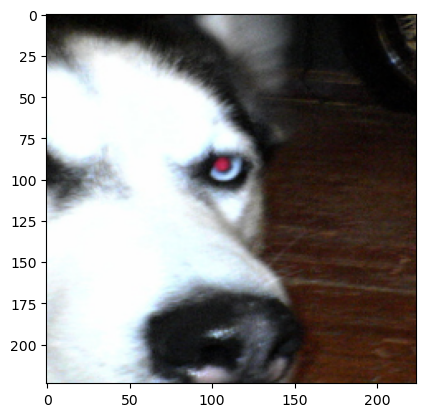

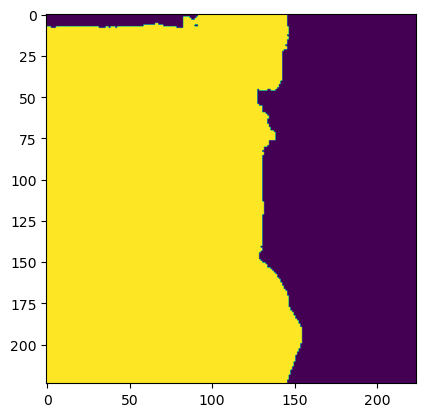

In [197]:
img, label, mask, noise = dset[200]
show_imarray(img)
plt.show()
show_imarray(mask, vmin=0, vmax=1)
plt.show()

In [8]:
# masks_to_boxes(totensor(mask))
bbox = BoundingBoxes(
    masks_to_boxes(to_image(mask)), format="XYXY", canvas_size=img.size[::-1]
)

TypeError: 'builtin_function_or_method' object is not subscriptable

In [ ]:
img_trans, bbox_trans, mask_trans = transform_shared_augment(img, bbox, mask)
show_imarray(img_trans)
plt.show()
show_imarray(mask_trans)
plt.show()

In [199]:
dloader = get_dloader("train", 4, data_dir, noise=True)

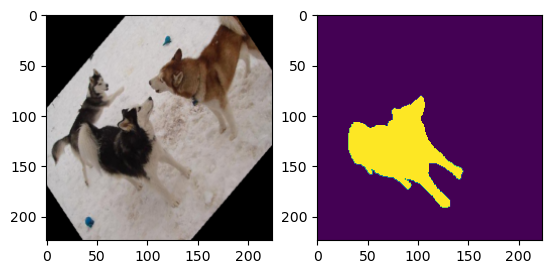

In [470]:
imgs, labels, masks, noise = next(iter(dloader))
fig, (ax0, ax1) = plt.subplots(1, 2)
show_imarray(imgs[0], ax=ax0)
show_imarray(masks[0], ax=ax1)